Pull in the data for the water flow 

In [1]:
import pandas as pd
import csv
import requests
import os
from bs4 import BeautifulSoup
import re

In [2]:
# change to the path with the raw csv file
path=r'C:\Springboard\Github\River_Analysis'
os.chdir(path)

### Enter your USGS gage number below (it must be in quotes)

In [3]:
GAGE = '09404200'

### ^ Enter your USGS gage number above ^

In [4]:
# function for pulling the date range for reach USGS gage
# takes in string of the gage number with USGS
def pull_start(USGS):
    link = "https://waterdata.usgs.gov/nwis/dv?referred_module=sw&site_no=" + USGS
    response = requests.get(link)
    soup = BeautifulSoup(response.text, "html.parser")
    site_sum = soup.find_all(id='available_parameters_table')
    rows_sum = site_sum[0].find_all('tr')
    for row in rows_sum:
        cell_sum = row.find_all('td')
        for i, cell in enumerate(cell_sum):
            if 'discharge' in cell.get_text().lower():
                # get start date from the next cell
                start_date = re.findall(r'\d{4}-\d{2}-\d{2}', cell_sum[i+1].get_text())[0]
                end_date = re.findall(r'\d{4}-\d{2}-\d{2}', cell_sum[i+2].get_text())[0]
                # re.findall(r'\d{4}-\d{2}-\d{2}', cell[next].get_text())[0]
                return start_date, end_date
    return 0, 0

In [5]:
# this function pulls the water date from a given gage from start_date to end_date
raw_file = GAGE + '.csv'
def pull_water(USGS, start_date, end_date):
    link_begin = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no='
    link_mid = '&referred_module=sw&period=&begin_date='
    link_end = '&end_date='
    link = link_begin + USGS + link_mid + start_date + link_end + end_date
    response = requests.get(link)
    # raw_file = USGS + '.csv'
    with open(raw_file, 'wb') as f:
        for chunk in response:
            f.write(chunk)

# this gets a raw file of the data

In [6]:
# pulls the data for just one gage
start_date, end_date = pull_start(GAGE)
pull_water(GAGE, start_date, end_date)


In [7]:
# See 06_data_extraction from gauge_info

# read the raw CSV back in and remove the commented lines
# open raw CSV
fi = open(raw_file, 'r')

# read raw CSV to clean CSV - eliminate comment rows with "#"
clean_file = 'clean.csv'
with open(clean_file, 'w') as fo:
    lines = fi.readlines()
    for line in lines:
        if "#" not in line:
            fo.write(line)
fi.close()

In [8]:
# load daily water flow into a DF
flow = pd.read_csv(clean_file, error_bad_lines=False, delimiter='\t')
flow

,agency_cd,site_no,datetime,5370_00060_00003,5370_00060_00003_cd
0,5s,15s,20d,14n,10s
1,USGS,09404200,1983-08-23,16800,A
2,USGS,09404200,1983-08-24,17300,A
3,USGS,09404200,1983-08-25,17300,A
4,USGS,09404200,1983-08-26,15300,A
...,...,...,...,...,...
13952,USGS,09404200,2021-11-02,8130,P
13953,USGS,09404200,2021-11-03,8790,P
13954,USGS,09404200,2021-11-04,9290,P
13955,USGS,09404200,2021-11-05,9140,P


That looks pretty good. I would like to include more of the summer, but that can happen later. Let's drop some of the useless columns and rows.

In [9]:
# drop the first row - that looks like useless data
flow.drop(0, inplace=True)
flow

,agency_cd,site_no,datetime,5370_00060_00003,5370_00060_00003_cd
1,USGS,09404200,1983-08-23,16800,A
2,USGS,09404200,1983-08-24,17300,A
3,USGS,09404200,1983-08-25,17300,A
4,USGS,09404200,1983-08-26,15300,A
5,USGS,09404200,1983-08-27,16500,A
...,...,...,...,...,...
13952,USGS,09404200,2021-11-02,8130,P
13953,USGS,09404200,2021-11-03,8790,P
13954,USGS,09404200,2021-11-04,9290,P
13955,USGS,09404200,2021-11-05,9140,P


In [10]:
# rename columns to make for easier dropping
flow.columns = ['agency', 'gage', 'date', 'y', 'useless']
flow

,agency,gage,date,y,useless
1,USGS,09404200,1983-08-23,16800,A
2,USGS,09404200,1983-08-24,17300,A
3,USGS,09404200,1983-08-25,17300,A
4,USGS,09404200,1983-08-26,15300,A
5,USGS,09404200,1983-08-27,16500,A
...,...,...,...,...,...
13952,USGS,09404200,2021-11-02,8130,P
13953,USGS,09404200,2021-11-03,8790,P
13954,USGS,09404200,2021-11-04,9290,P
13955,USGS,09404200,2021-11-05,9140,P


In [11]:
flow.drop(['agency', 'gage', 'useless'], axis=1, inplace=True)
flow

,date,y
1,1983-08-23,16800
2,1983-08-24,17300
3,1983-08-25,17300
4,1983-08-26,15300
5,1983-08-27,16500
...,...,...
13952,2021-11-02,8130
13953,2021-11-03,8790
13954,2021-11-04,9290
13955,2021-11-05,9140


In [12]:
flow['y'] = flow['y'].astype(float)

In [13]:
# let's check for NaN values
flow['y'].isna().value_counts()

False    11892
True      2064
Name: y, dtype: int64

In [14]:
# instead of assuming it's all filled, let's fill it
# let's check for NaN values
flow['y'].fillna(method='backfill', inplace=True)

that looks all filled to me. Time to rename the date column and run FB prophet

In [15]:
flow.rename(columns={'date':'ds'}, inplace=True)

Next steps: how do I get the min / max / median / mean from each independent calendar day? <br>
<br>
Perhaps group by month and day

In [16]:
# add day and month columns to the existing DF
flow["Month"] = flow['ds'].str[5:7]
flow["Day"] = flow['ds'].str[8:10]
flow['MD'] = flow["Month"] + '-' + flow["Day"]

In [17]:
flow.dtypes

ds        object
y        float64
Month     object
Day       object
MD        object
dtype: object

In [18]:
flow['Month'] = flow['Month'].astype(int)
flow['Day'] = flow['Day'].astype(int)

In [19]:
summary = flow.groupby(["MD"], as_index=False)['y'].agg(['mean', 'min', 'median', 'max']) #
summary

,mean,min,median,max
MD,,,,
01-01,14002.631579,5900.0,13300.0,24000.0
01-02,14050.000000,8300.0,13600.0,24000.0
01-03,13521.842105,8700.0,13250.0,24000.0
01-04,14454.210526,9860.0,14400.0,24000.0
01-05,15089.473684,11300.0,14600.0,24000.0
...,...,...,...,...
12-27,12923.684211,6100.0,12250.0,24000.0
12-28,13929.210526,9500.0,13600.0,24000.0
12-29,14136.842105,10500.0,13900.0,24000.0


In [20]:
# let's check these values
summary.describe()

,mean,min,median,max
count,366.000000,366.000000,366.000000,366.000000
mean,13562.172352,8296.967213,12920.491803,25370.765027
std,1260.845781,1496.623903,1476.242278,5416.872976
min,11199.487179,4600.000000,10400.000000,15800.000000
25%,12609.615385,7470.000000,11800.000000,22000.000000
50%,13391.973684,8605.000000,12425.000000,24000.000000
75%,14448.881579,9037.500000,14125.000000,26100.000000
max,16088.421053,11800.000000,16100.000000,46700.000000


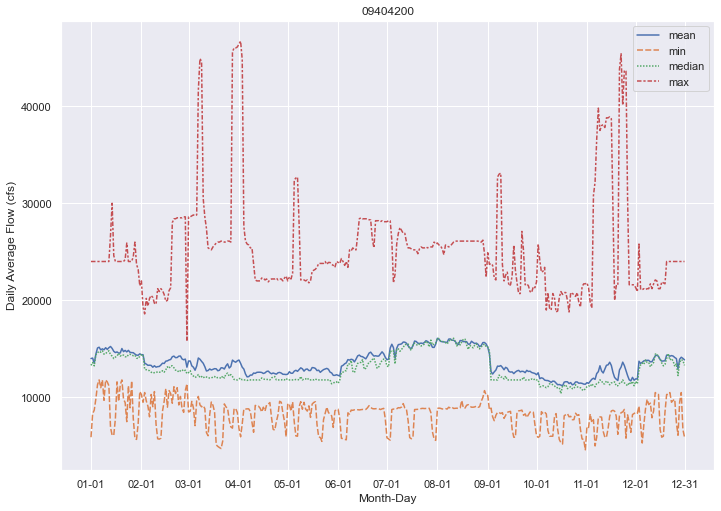

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
# set the figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# create the plot
g  = sns.lineplot(data=summary) # , x='MD', y=['min', 'mean', 'max', 'median'])
_ = plt.xticks(['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01', '12-31'])
plt.xlabel('Month-Day')
plt.ylabel('Daily Average Flow (cfs)')
plt.title(GAGE)
plt.savefig('Salt_River_without_max.png',bbox_inches='tight')
# g.set_xticks(25)

# g.set_xticklabels(['0','a','b','c','d','e'])
# need to resize
# need to space the markers out more
# need to save this plot so we can add it to a HTML site